In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.svm import SVR
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor
from pathlib import Path
import json
import pickle

import warnings
warnings.filterwarnings("ignore")

In [6]:
ROOT_DIR = Path.cwd().resolve().parent
DATA_DIR = ROOT_DIR / "data"
MODELS_DIR = ROOT_DIR / "models"
PREDICTIONS_DIR = ROOT_DIR / "predictions"

df = pd.read_excel(DATA_DIR / "data1_logs_hourly.xlsx", index_col=0)

# 1. Feature Engineering

In [7]:
# 1. Календарные признаки
df['year'] = df.index.year
df['month'] = df.index.month
df['day'] = df.index.day
df['hour'] = df.index.hour
df['weekday'] = df.index.weekday
df['day_of_year'] = df.index.dayofyear
df['is_weekend'] = df['weekday'].apply(lambda x: 1 if x >= 5 else 0)

df['campaign_days_elapsed'] = df.groupby('year').cumcount() + 1
df['campaign_days_remained'] = df.groupby('year')['campaign_days_elapsed'].transform('max') - df['campaign_days_elapsed']

# 2. Цикличные признаки
df['sin_weekday'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['cos_weekday'] = np.cos(2 * np.pi * df['weekday'] / 7)
df['sin_hour'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_hour'] = np.cos(2 * np.pi * df['hour'] / 24)

# Далее будем преобразовывать только train для предотвращения утечки данных
df = df.reset_index()
train = df[df['year'] < 2024]
test = df[df['year'] == 2024]

# 3. Лаговые признаки
lags = [1, 3, 6, 24, 48, 72, 168]
for lag in lags:
    #df[f'y_lag_{lag}'] = df.groupby('year')['y'].shift(lag) # лаги берем только внутри года
    train[f'y_lag_{lag}'] = train['y'].shift(lag)

# 4. Скользящие средние
windows = [3, 12, 24, 48, 72, 168]
for window in windows:
    #df[f'ma_{window}'] = df.groupby('year')['y'].shift(1).rolling(window=window, min_periods=1).mean() # не учитываем текущий день
    train[f'ma_{window}'] = train['y'].shift(1).rolling(window=window).mean()

train = train.dropna().reset_index(drop=True)

X_train = train.drop(columns=['y', 'date'])
X_test = test.drop(columns=['y', 'date'])
y_train = train['y'].values
y_test = test['y'].values

In [8]:
X_train.head()

,year,month,day,hour,weekday,day_of_year,is_weekend,campaign_days_elapsed,campaign_days_remained,sin_weekday,...,y_lag_24,y_lag_48,y_lag_72,y_lag_168,ma_3,ma_12,ma_24,ma_48,ma_72,ma_168
0,2014,6,27,10,4,178,0,169,685,-0.433884,...,29.0,34.0,30.0,2.0,0.000000,0.000000,21.333333,20.645833,18.402778,10.053571
1,2014,6,27,11,4,178,0,170,684,-0.433884,...,47.0,50.0,31.0,5.0,9.333333,2.333333,21.291667,20.520833,18.375000,10.208333
2,2014,6,27,12,4,178,0,171,683,-0.433884,...,74.0,61.0,45.0,7.0,27.000000,6.750000,21.541667,20.583333,18.680556,10.494048
3,2014,6,27,13,4,178,0,172,682,-0.433884,...,86.0,80.0,47.0,7.0,47.000000,11.750000,20.958333,20.562500,18.888889,10.809524
4,2014,6,27,14,4,178,0,173,681,-0.433884,...,87.0,77.0,53.0,7.0,61.666667,17.750000,20.375000,20.395833,19.236111,11.196429


In [15]:
def make_forecast(model, X_test, y_test, initial_lags, lags=lags, windows=windows, mode='recursive'):
    test_df = X_test.reset_index(drop=True)

    forecasts = []
    cur_window = list(initial_lags)

    for idx, row in test_df.iterrows():
        new_features = {
            'year': row['year'],
            'month': row['month'],
            'day': row['day'],
            'hour': row['hour'],
            'weekday': row['weekday'],
            'day_of_year': row['day_of_year'],
            'is_weekend': row['is_weekend'],
            'campaign_days_elapsed': row['campaign_days_elapsed'],
            'campaign_days_remained': row['campaign_days_remained'],
            'sin_weekday': row['sin_weekday'],
            'cos_weekday': row['cos_weekday'],
            'sin_hour': row['sin_hour'],
            'cos_hour': row['cos_hour']
        }
        
        for lag in lags:
            new_features[f'y_lag_{lag}'] = cur_window[-lag]

        for window in windows:
            new_features[f'ma_{window}'] = np.mean(cur_window[-window:]) if len(cur_window) >= window else np.mean(cur_window)

        input_df = pd.DataFrame([new_features])

        y_hat = model.named_steps['regressor'].predict(model.named_steps['feature_selection'].transform(input_df))[0]
        forecasts.append(y_hat)

        cur_window.pop(0)
        if mode == 'iterative':
            cur_window.append(y_test[idx])
        elif mode == 'recursive':
            cur_window.append(y_hat)
        else:
            raise ValueError("Invalid mode. Use 'iterative' or 'recursive'")

    return np.array(forecasts)

def plot(y_pred, y_test, title='', interval=7, figsize=(12, 6), dates=df[df['year'] == 2024]['date']):
    fix, ax = plt.subplots(figsize=figsize)
    ax.plot(dates, y_test, label='Фактические данные', color='blue')
    ax.plot(dates, y_pred, label='Прогноз', color='red')
    
    ax.set_xlabel('Дата')
    ax.set_ylabel('Количество заявок')
    ax.set_title(title)

    locator = mdates.DayLocator(interval=interval)
    ax.xaxis.set_major_locator(locator)

    ax.legend()
    ax.grid()
    plt.show()

def print_metrics(y_test, y_pred):
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")

# 2. Построение моделей

## 2.1. Random Forest Regressor

In [ ]:
pipeline = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', RandomForestRegressor(random_state=42))
])

In [ ]:
cv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'feature_selection__k': [5, 10, 15],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [5, 10, None],
}

In [13]:
gs = GridSearchCV(pipeline, param_grid, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=3)
gs.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x00000221811A2320>)),
                                       ('regressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 10, 15],
                         'regressor__max_depth': [5, 10, None],
                         'regressor__n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=3)

In [ ]:
print(f"Best params: {gs.best_params_}")
print(f"Best score: {-gs.best_score_}")

Best params: {'feature_selection__k': 15, 'regressor__max_depth': None, 'regressor__n_estimators': 200}
Best score: 8.973602121667826


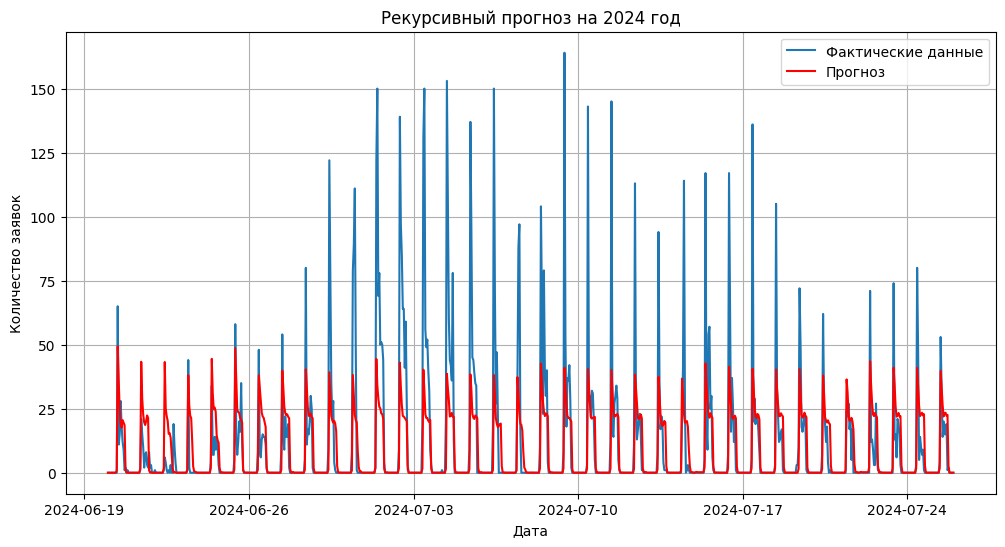

In [ ]:
best_model = gs.best_estimator_

initial_lags = y_train[-168:]
y_pred_rec = make_forecast(best_model, X_test, y_test, initial_lags, mode='recursive')

dates = df[df['year'] == 2024]['date']

plot(y_pred_rec, y_test, title='Рекурсивный прогноз на 2024 год')

In [24]:
print_metrics(y_test, y_pred_rec)

RMSE: 18.504533028222912
MAE: 7.40005787037037


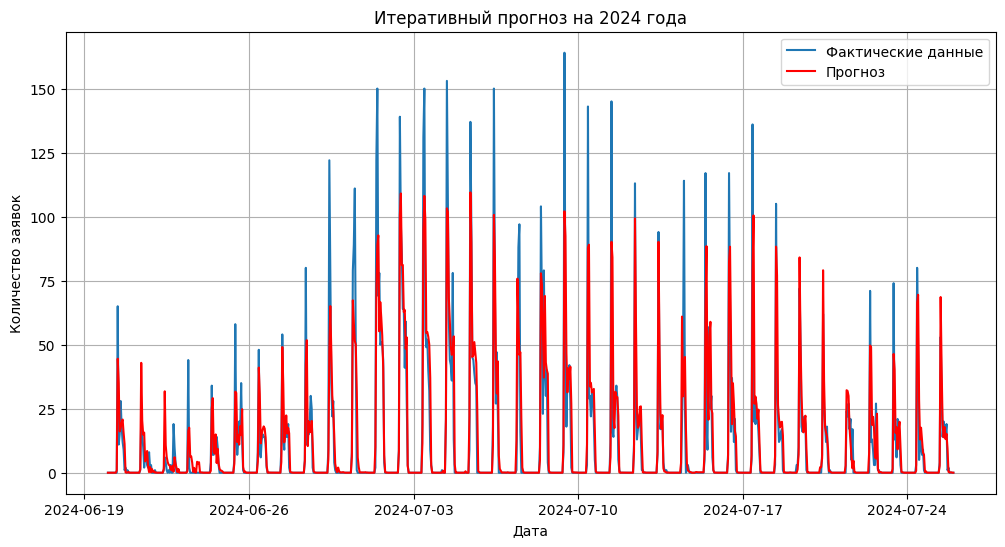

In [25]:
initial_lags = y_train[-168:]
y_pred_iter = make_forecast(best_model, X_test, y_test, initial_lags, mode='iterative')

plot(y_pred_iter, y_test, title='Итеративный прогноз на 2024 года')

In [26]:
print_metrics(y_test, y_pred_iter)

RMSE: 12.368072733783068
MAE: 5.029074074074074


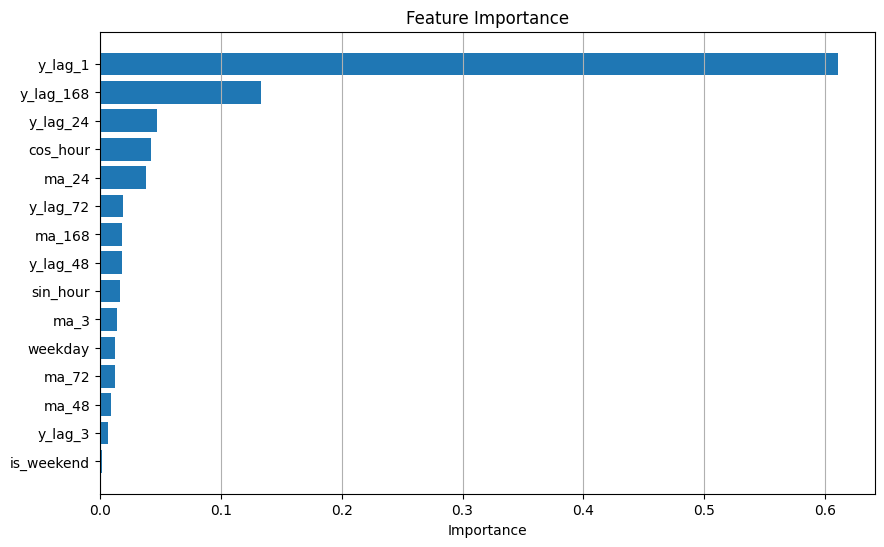

In [27]:
features = X_train.columns[best_model.named_steps['feature_selection'].get_support()]
importances = best_model.named_steps['regressor'].feature_importances_

importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.show()

## 2.2. SVR

In [7]:
pipeline_svr = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', SVR())
])

param_grid_svr = {
    'feature_selection__k': [10, 15],
    'regressor__kernel': ['linear', 'rbf'],
    'regressor__C': [0.1, 1, 10],
    'regressor__epsilon': [0.1, 0.5, 1]
}

cv = TimeSeriesSplit(n_splits=5)

In [ ]:
gs_svr = GridSearchCV(pipeline_svr, param_grid_svr, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
gs_svr.fit(X_train, y_train)

In [10]:
print(f"Best params: {gs_svr.best_params_}")
print(f"Best score: {-gs_svr.best_score_}")

Best params: {'feature_selection__k': 15, 'regressor__C': 10, 'regressor__epsilon': 1, 'regressor__kernel': 'rbf'}
Best score: 9.014845473528398


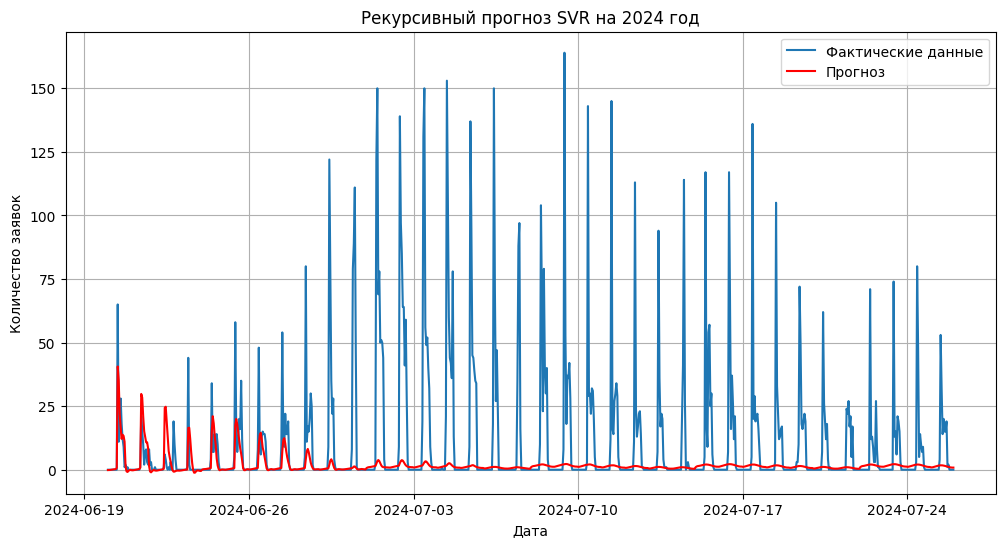

RMSE: 26.67789652601181
MAE: 10.74500613452309


In [11]:
best_model_svr = gs_svr.best_estimator_

initial_lags = y_train[-168:]
y_pred_rec_svr = make_forecast(best_model_svr, X_test, y_test, initial_lags, mode='recursive')

plot(y_pred_rec_svr, y_test, title='Рекурсивный прогноз SVR на 2024 год')
print_metrics(y_test, y_pred_rec_svr)

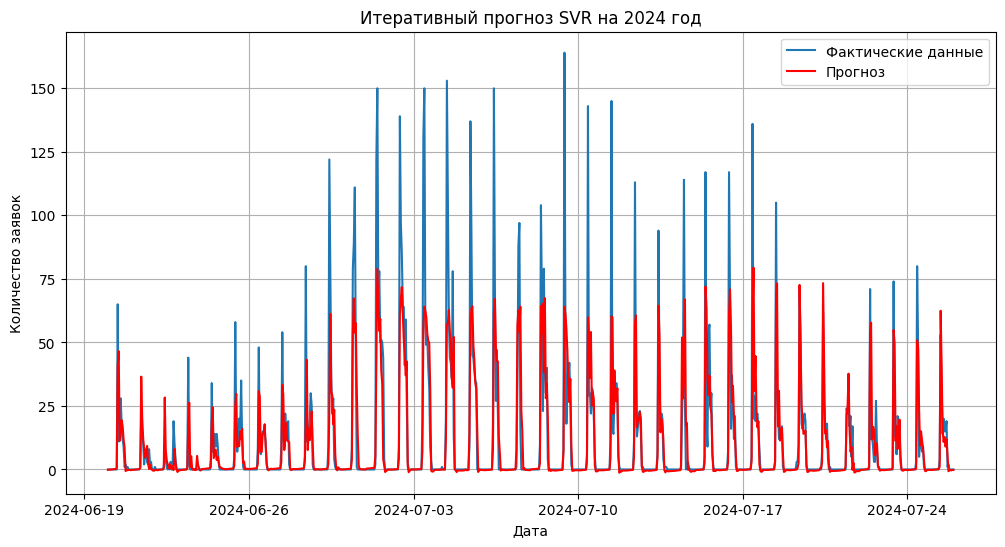

RMSE: 14.809569041247913
MAE: 5.632346505991354


In [12]:
y_pred_iter_svr = make_forecast(best_model_svr, X_test, y_test, initial_lags, mode='iterative')
plot(y_pred_iter_svr, y_test, title='Итеративный прогноз SVR на 2024 год')
print_metrics(y_test, y_pred_iter_svr)

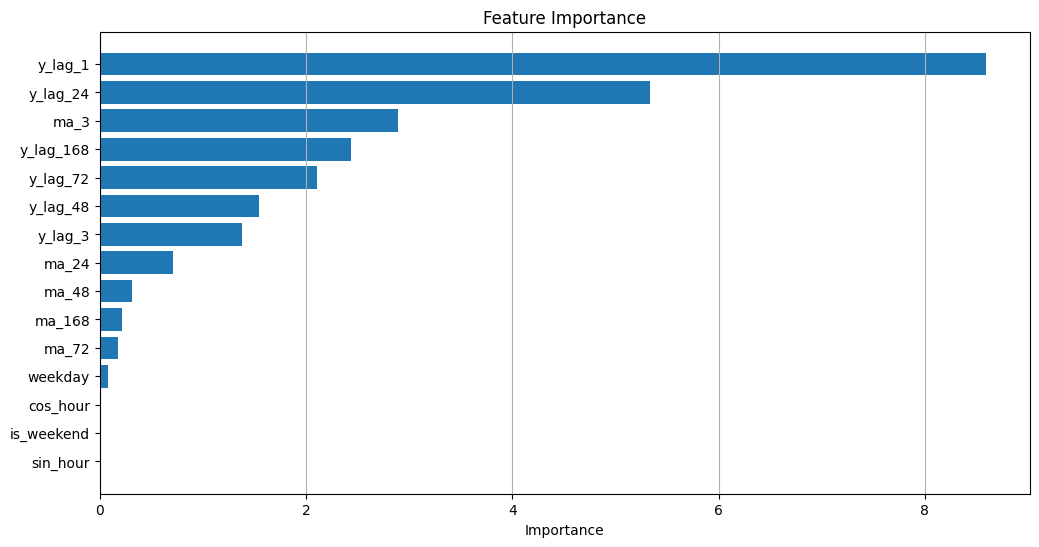

In [13]:
result = permutation_importance(
    best_model_svr.named_steps['regressor'],
    best_model_svr.named_steps['feature_selection'].transform(X_train),
    y_train,
    scoring='neg_root_mean_squared_error',
    random_state=42
)

features = X_train.columns[best_model_svr.named_steps['feature_selection'].get_support()]
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance')

plt.figure(figsize=(12, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

## 2.3. XGB Regressor

In [10]:
pipeline_xgb = Pipeline([
    ('feature_selection', SelectKBest(score_func=f_regression)),
    ('regressor', XGBRegressor(random_state=0))
])

param_grid_xgb = {
    'feature_selection__k': [5, 10, 15],
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.3],
    'regressor__subsample': [0.8, 1.0]
}

cv = TimeSeriesSplit(n_splits=5)

In [11]:
gs_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=cv, scoring='neg_root_mean_squared_error', n_jobs=-1, verbose=2)
gs_xgb.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectKBest(score_func=<function f_regression at 0x000002DC5E31D900>)),
                                       ('regressor',
                                        XGBRegressor(base_score=None,
                                                     booster=None,
                                                     callbacks=None,
                                                     colsample_bylevel=None,
                                                     colsample_bynode=None,
                                                     colsample_bytree=None,
                                                     device=None,
                                                     e...
                                                     monotone_constraints=None,
                                                     multi_strategy=None,
                                                     n_estimators=None,
                                                     n_jobs=None,
                                                     num_parallel_tree=None, ...))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [5, 10, 15],
                         'regressor__learning_rate': [0.01, 0.1, 0.3],
                         'regressor__max_depth': [3, 5, 7],
                         'regressor__n_estimators': [50, 100, 200],
                         'regressor__subsample': [0.8, 1.0]},
             scoring='neg_root_mean_squared_error', verbose=2)

In [12]:
print(f"Best params: {gs_xgb.best_params_}")
print(f"Best score: {-gs_xgb.best_score_}")

Best params: {'feature_selection__k': 15, 'regressor__learning_rate': 0.1, 'regressor__max_depth': 5, 'regressor__n_estimators': 100, 'regressor__subsample': 0.8}
Best score: 8.670235729217529


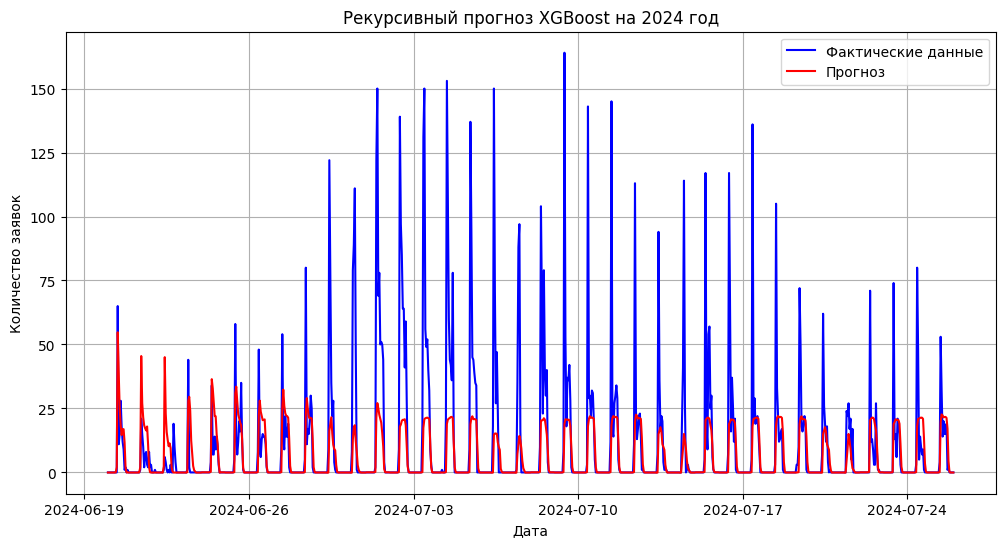

RMSE: 21.714645239356173
MAE: 7.889791965484619


In [16]:
best_model_xgb = gs_xgb.best_estimator_
initial_lags = y_train[-168:]
y_pred_rec_xgb = make_forecast(best_model_xgb, X_test, y_test, initial_lags, mode='recursive')
plot(y_pred_rec_xgb, y_test, title='Рекурсивный прогноз XGBoost на 2024 год')
print_metrics(y_test, y_pred_rec_xgb)

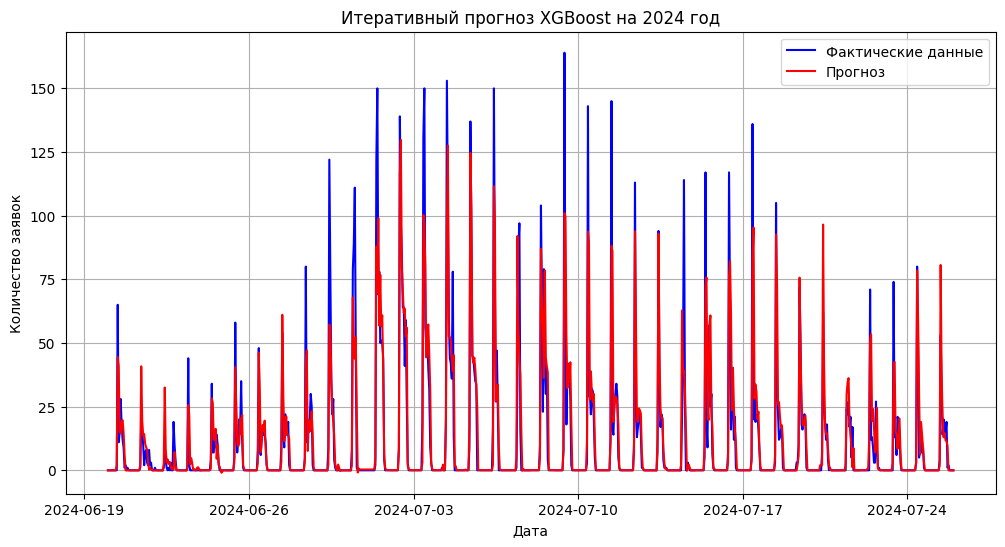

RMSE: 12.32817884078072
MAE: 4.872323513031006


In [17]:
y_pred_iter_xgb = make_forecast(best_model_xgb, X_test, y_test, initial_lags, mode='iterative')
plot(y_pred_iter_xgb, y_test, title='Итеративный прогноз XGBoost на 2024 год')
print_metrics(y_test, y_pred_iter_xgb)

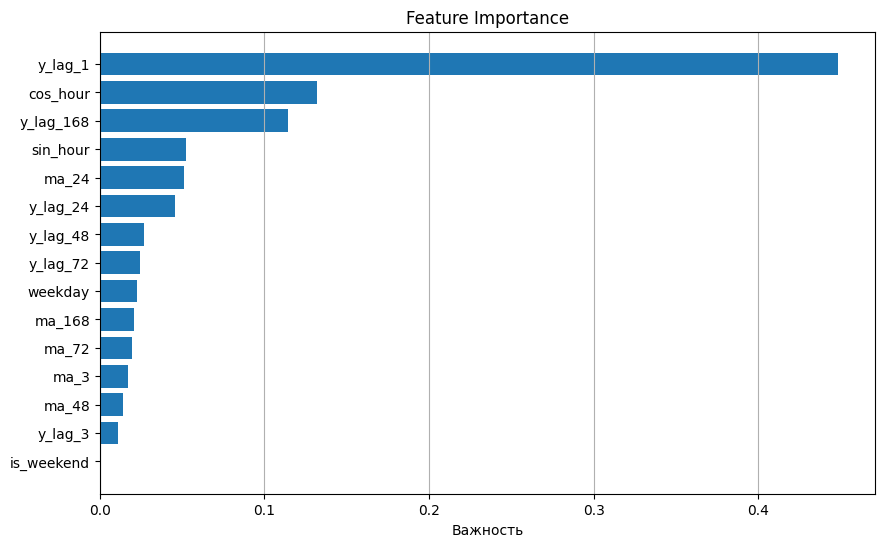

In [18]:
features = X_train.columns[best_model_xgb.named_steps['feature_selection'].get_support()]
importances = best_model_xgb.named_steps['regressor'].feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance')

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Важность')
plt.title('Feature Importance')
plt.grid(axis='x')
plt.show()

In [19]:
# Лучшая модель – XGBoost
with open(MODELS_DIR / "xgb_hourly_model.pkl", "wb") as file:
    pickle.dump(best_model_xgb, file)

with open(PREDICTIONS_DIR / "xgb_hourly_predictions.json", "w") as file:
    json.dump(y_pred_iter_xgb.tolist(), file)

# 3. Дополнительный анализ

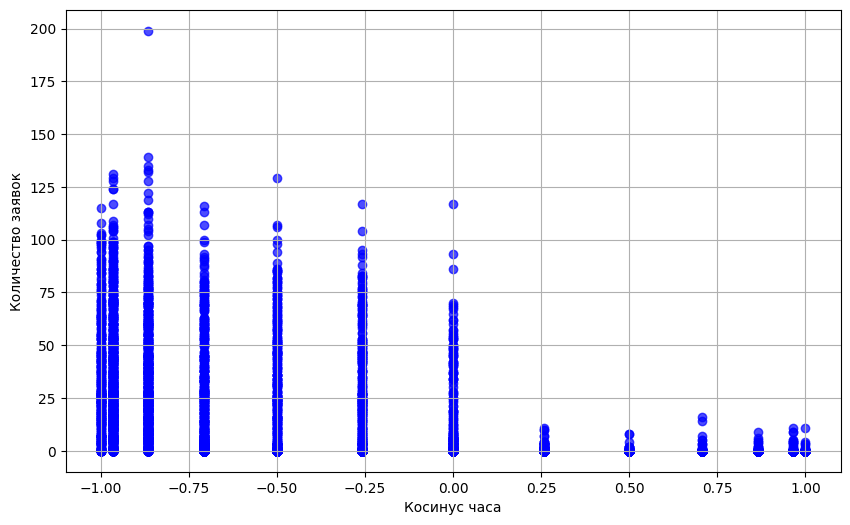

In [ ]:
# Зависимость между cos_hour и количеством заявок
df_train = df[df['year'] < 2024].copy()

plt.figure(figsize=(10, 6))
plt.scatter(df_train['cos_hour'], df_train['y'], alpha=0.7, color='blue')
plt.xlabel('Косинус часа')
plt.ylabel('Количество заявок')
plt.grid(True)
plt.show()